# Simple regression PoC

In this notebook we try to use the library instead of putting everything in a notebook

In [1]:
from typing import NamedTuple
import chex
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import (run_cv_sel, fold_posterior,
    estimate_elpd, rhat_summary, mv_ess_folds, pred_ess_folds)
from pcv.welford import *
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
# y = y.at[23].set(75.0)  # outlier

In [5]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

model_A_folds = jnp.array([0, 1, 2, 3, 4])
model_B_folds = jnp.array([5, 6, 7, 8, 9])

def logjoint_density(theta: Theta, fold_id: int = -1) -> chex.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set, use -1 for all data.
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    mask = 1.0 * ((jnp.arange(N) % 5) != fold_id)
    ll_contribs = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (mask * ll_contribs).sum()
    return lp + ll + sigsq_ldj


# # within-sample density log p(y|theta)
# def log_p(theta):
#     # transform to constrained space
#     sigsq = sigsq_t.forward(theta.sigsq)
#     esq = ((X @ theta.beta - y) ** 2).sum()
#     return -0.5 * (
#         N * jnp.log(2 * jnp.pi)
#         + N * jnp.log(sigsq)
#         + esq/sigsq
#     )


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = 1.0 * ((jnp.arange(N) % 5) == fold_id)
    npred = pred_mask.sum()
    esq = ((X @ theta.beta - y) ** 2) * pred_mask
    return -0.5 * (
        npred * jnp.log(2 * jnp.pi)
        + npred * jnp.log(sigsq)
        + esq.sum()/sigsq
    )


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

Ok let's actually run some MCMC

In [6]:
inference_key = jax.random.PRNGKey(42)

Run the full-data posterior with the offline inference loop, saving draws.

In [7]:
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       model_A_folds=jnp.array([0, 1, 2, 3, 4]),
       model_B_folds=jnp.array([5, 6, 7, 8, 9]),
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50
)

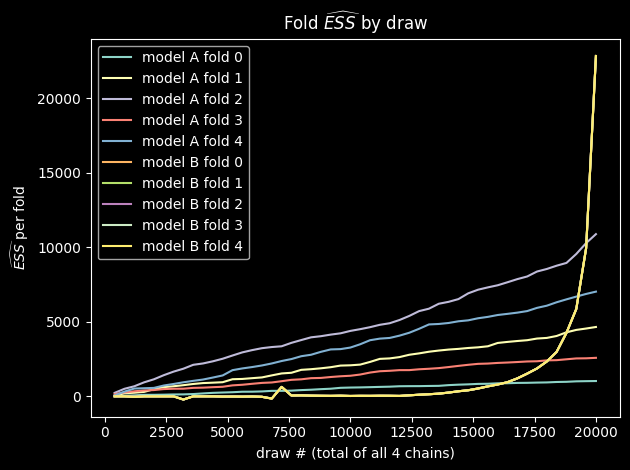

In [8]:
plt.plot(results['draws'], results['ess'])
plt.title(r'Fold $\widehat{ESS}$ by draw')
plt.legend([f'model {"A" if i <= 4 else "B"} fold {i % 5}' for i in range(10)])
plt.xlabel('draw # (total of all 4 chains)')
plt.ylabel(r'$\widehat{ESS}$ per fold')
plt.tight_layout()
plt.show()

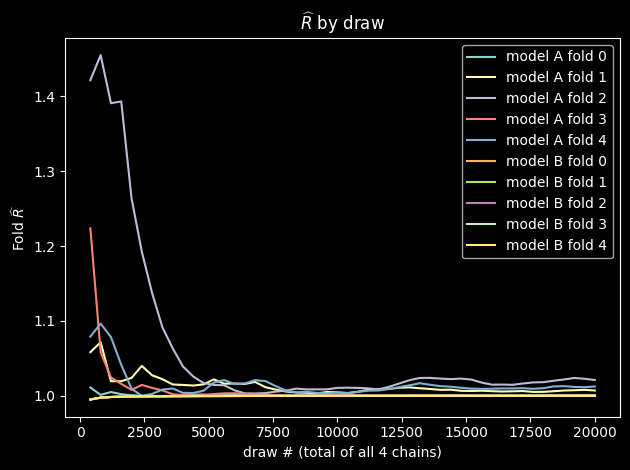

In [9]:
plt.plot(results['draws'], results['rhat'])
plt.title(r'$\widehat{R}$ by draw')
plt.legend([f'model {"A" if i <= 4 else "B"} fold {i % 5}' for i in range(10)])
plt.xlabel('draw # (total of all 4 chains)')
plt.ylabel(r'Fold $\widehat{R}$')
plt.tight_layout()
plt.show()